# Flux Variability Anlysis (FVA)

Load a few packages and functions.

In [49]:
import pandas
pandas.options.display.max_rows = 12
import escher
from cameo import models, flux_variability_analysis, fba

First we load a model from the [BiGG](http://bigg.ucsd.edu/) database (and make a copy of it).

In [50]:
model = models.bigg.e_coli_core.copy()

## Run flux variablity analysis

Calculate all flux ranges of all reactions in the model.

In [51]:
result = flux_variability_analysis(model)

Inspect the result.

In [52]:
result.data_frame

,upper_bound,lower_bound
ACALD,-5.892581e-28,-2.000000e+01
ACALDt,-1.018706e-30,-2.000000e+01
ACKr,0.000000e+00,-2.000000e+01
ACONTa,2.000000e+01,-4.572994e-31
ACONTb,2.000000e+01,2.832972e-30
ACt2r,4.886876e-29,-2.000000e+01
...,...,...
SUCOAS,0.000000e+00,-2.000000e+01
TALA,2.000000e+01,-1.545362e-01
THD2,3.332200e+02,0.000000e+00


Get an overview of a few key statistics of the resulting flux ranges.

In [53]:
result.data_frame.describe()

,upper_bound,lower_bound
count,9.500000e+01,95.000000
mean,8.625296e+01,-7.282128
std,1.782831e+02,14.716513
min,-4.794286e-01,-68.305000
25%,3.452684e-29,-10.000000
50%,2.000000e+01,0.000000
75%,9.830500e+01,0.000000
max,1.000000e+03,8.390000


Visualize the flux ranges.

In [54]:
result.plot(index=result.data_frame.index, height=1200)

Visualize the flux ranges on a pathway map of _E. coli's_ central carbon metabolism.

In [55]:
abs_flux_ranges = abs(result.data_frame.lower_bound - result.data_frame.upper_bound).to_dict()
escher.Builder('e_coli_core.Core metabolism', reaction_data=abs_flux_ranges).display_in_notebook()

Those reactions showing up in red are futile cyles.

In [56]:
result.data_frame[result.data_frame.upper_bound > 500]

,upper_bound,lower_bound
FORt2,666.44,0.0
FORti,666.44,0.0
FRD7,1000.00,0.0
SUCDi,1000.00,0.0


In [57]:
result_no_cyles = flux_variability_analysis(model, remove_cycles=True)

In [58]:
abs_flux_ranges = abs(result_no_cyles.data_frame.lower_bound - result_no_cyles.data_frame.upper_bound).to_dict()
escher.Builder('e_coli_core.Core metabolism', reaction_data=abs_flux_ranges).display_in_notebook()

## Run flux variability analysis for optimally growing _E. coli_

(Optimal) Flux Balance Analysis solutions are not necessariliy unique. Flux Variablity Analysis is a good tool for estimating the space of alternative optimal solutions.

In [13]:
fba(model)

In [14]:
model_optimal = model.copy()

In [15]:
model_optimal.reactions.BIOMASS_Ecoli_core_w_GAM.lower_bound = 0.8739215069684299

In [16]:
result_max_obj = flux_variability_analysis(model_optimal, remove_cycles=True)

In [17]:
result_max_obj.plot(index=result_max_obj.data_frame.index, height=1200)

This is actually such a common task that `flux_variability_analysis` provides an option for fixing the objective's flux at a certain percentage.

In [19]:
result_max_obj = flux_variability_analysis(model, fraction_of_optimum=1., remove_cycles=True)

In [20]:
result_max_obj.plot(index=result_max_obj.data_frame.index, height=1200)

Turns out that in this small core metabolic model, the optimal solution is actually unique!

In [61]:
sum(abs(result_max_obj.data_frame.lower_bound - result_max_obj.data_frame.upper_bound))

1.2156704039782733e-12

## Exercises

### Exercise 1

Explore how relaxing the constraint on the growth rate affects the solution space:
1. Modify the code to explore flux ranges for $\mu \gt 0.7 \ h^{-1}$ 
1. Plot the sum of flux ranges over a range of percentages.

### Exercise 2

Using FVA, determine all blocked reactions ($v = 0$) in the model.

## Solutions

### Solution 1

In [35]:
percentage = (0.7 / model.solve().f) * 100
percentage

80.09872676417456

In [38]:
result_80perc_max_obj = flux_variability_analysis(model, fraction_of_optimum=percentage/100, remove_cycles=True)

In [39]:
result_80perc_max_obj.plot(index=result_80perc_max_obj.data_frame.index, height=1200)

### Solution 2

In [40]:
flux_sums = []
optimum_percentages = range(50, 105, 5)
for i in optimum_percentages:
    df = flux_variability_analysis(model, fraction_of_optimum=i/100, remove_cycles=True).data_frame
    flux_sum = sum(abs(df.lower_bound - df.upper_bound))
    print("{}%: ".format(i), flux_sum)
    flux_sums.append(flux_sum)

50%:  3751.40240599
55%:  3424.27160795
60%:  3095.30744285
65%:  2766.01470946
70%:  2435.53815493
75%:  2093.28708667
80%:  1743.33172454
85%:  1390.11135124
90%:  1033.30596455
95%:  634.220801927
100%:  4.43464272321e-13


In [41]:
import matplotlib.pyplot as plt

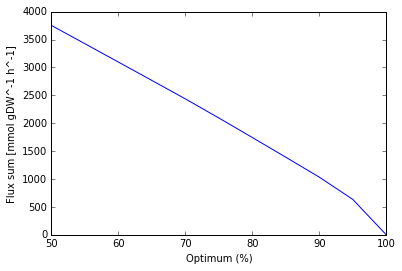

In [42]:
plt.plot(optimum_percentages, flux_sums)
plt.xlabel('Optimum (%)')
plt.ylabel('Flux sum [mmol gDW^-1 h^-1]')
plt.show()

### Solution 3

In [44]:
result = flux_variability_analysis(model, remove_cycles=True)

In [48]:
result.data_frame[(result.data_frame.lower_bound == 0) & (result.data_frame.upper_bound == 0)]

,upper_bound,lower_bound
EX_fru_e,0.0,0.0
EX_fum_e,0.0,0.0
EX_gln__L_e,0.0,0.0
EX_mal__L_e,0.0,0.0
FRD7,0.0,0.0
FRUpts2,0.0,0.0
FUMt2_2,0.0,0.0
GLNabc,0.0,0.0
MALt2_2,0.0,0.0
